# Actividad 3: Análisis de Préstamos Lending Club con PySpark

## 1. Introducción
En esta actividad se realiza un análisis de datos de préstamos de la plataforma Lending Club. Usaremos PySpark para procesar un conjunto de datos de gran tamaño, limpiarlo, explorarlo y extraer conclusiones relevantes para la toma de decisiones financieras.

## 2. Carga y exploración del dataset

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when,mean, stddev, count, desc,to_date, year
from collections import Counter, defaultdict

In [27]:
spark = SparkSession.builder.appName("LendingClubLoanData").getOrCreate()
spark

In [28]:
df = spark.read.option("header", True).option("inferSchema", True).csv("E:/Tareas/BigData/A3/loan.csv")
df.show(10)

+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+-------------------+----------+--------------+----------+-------------------+--------+-----------+----------+----+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+

In [29]:
filas = df.count()
columnas = len(df.columns)
print(f"Registros: {filas} | Columnas: {columnas}")


Registros: 2260668 | Columnas: 145


In [30]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: strin

In [31]:
tipos_dato = [field.dataType.simpleString() for field in df.schema.fields]
conteo_tipos = Counter(tipos_dato)
for tipo, cantidad in conteo_tipos.items():
    print(f"{tipo}: {cantidad} columnas")


string: 95 columnas
int: 42 columnas
double: 8 columnas


## 3. Limpieza de datos

In [32]:
total_rows = df.count()
resumen = defaultdict(lambda: {"con_muchos_nulos": 0, "pocos_nulos": 0})

# Recorremos columnas y analizamos por tipo
for campo in df.schema.fields:
    nombre = campo.name
    tipo = campo.dataType.simpleString()
    
    # Calcular cuántos nulos hay en la columna
    nulos = df.select((sum(when(col(nombre).isNull() | (col(nombre) == ''), 1).otherwise(0)) / total_rows).alias("nulo")).collect()[0]["nulo"]
    
    # Clasificamos según los criterios
    if nulos > 0.2:
        resumen[tipo]["con_muchos_nulos"] += 1
    elif nulos < 0.2:
        resumen[tipo]["pocos_nulos"] += 1

# Mostrar el resumen
print("Tipo\t|\t>20% nulos\t|\t<20% nulos")
for tipo, valores in resumen.items():
    print(f"{tipo}\t|\t{valores['con_muchos_nulos']}\t\t|\t{valores['pocos_nulos']}")


Tipo	|	>20% nulos	|	<20% nulos
string	|	46		|	49
int	|	11		|	31
double	|	1		|	7


In [33]:
total_rows = df.count()

porcentaje_nulos = df.select([(sum(when(col(c).isNull() | (col(c) == ''), 1).otherwise(0)) / total_rows).alias(c)for c in df.columns])
porcentaje_nulos_pd = porcentaje_nulos.toPandas().T
porcentaje_nulos_pd.columns = ["porcentaje_nulo"]
columnas_validas = porcentaje_nulos_pd[porcentaje_nulos_pd["porcentaje_nulo"] < 0.2].index.tolist()
df_clean = df.select(*columnas_validas)
print(f"Columnas seleccionadas: {len(columnas_validas)}")


Columnas seleccionadas: 87


In [34]:
df_clean.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- inq_last_6mths: string (nullab

In [35]:
string_columns = [col.name for col in df_clean.schema.fields if col.dataType.simpleString() == 'string']
numeric_columns = [col.name for col in df_clean.schema.fields if col.dataType.simpleString() != 'string']

df_strings = df_clean.select(string_columns)
df_numerics = df_clean.select(numeric_columns)

In [36]:
df_strings.show(10)
df_numerics.show(10)

+----------+-----+---------+-------------------+----------+--------------+----------+-------------------+--------+-----------+----------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+--------------------------+-----------+----------------+--------------+------------+-----------+----------------+-----------+-------+-------------+-------------------+--------------------+
|      term|grade|sub_grade|          emp_title|emp_length|home_ownership|annual_inc|verification_status| issue_d|loan_status|pymnt_plan|           purpose|               title|zip_code|addr_state|  dti|delinq_2yrs|earliest_cr_line|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_stat

In [37]:
len(df_strings.columns)

49

In [38]:
len(df_numerics.columns)

38

## 4. Análisis descriptivo y agrupaciones

In [39]:
df_strings.describe().show()

+-------+----------+-------+---------+------------------+----------+--------------+-----------------+-------------------+---------------+-----------+-----------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+------------------+------------------+------------------+--------------------------+------------------+-----------------+--------------------+-----------------+------------------+------------------+------------------+------------------+-------------+-------------------+--------------------+
|summary|      term|  grade|sub_grade|         emp_title|emp_length|home_own

In [40]:
df_numerics.describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+------------------------+------------------+------------------+--------------------+---------------------+-----------------+------------------+--------------------+---------------------+---------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+------------------+--------------------+--------------------+-------------------+------------------+-----------------+------------------+--------------------+-------------------+------------------+-----------------+------------------+--------------------------+
|summary|         loan_amnt|       funded_amnt|   funded_amnt_inv|         int_rate|       installment|acc_open_past_24mths|    bc_open_to_buy|chargeoff_within_12_mths|       delinq_amnt|mo_sin_old_il_acct|mo_sin_old_rev_tl_op|mo_sin_r

In [41]:
df_clean.groupBy("loan_status").count().orderBy("count", ascending=False).show()
df_clean.groupBy("home_ownership").agg({"int_rate": "avg"}).show()
df_clean.groupBy("grade").avg("loan_amnt", "int_rate").orderBy("grade").show()
df_clean.groupBy("purpose").count().orderBy("count", ascending=False).show()
df_clean = df_clean.withColumn("issue_date", to_date("issue_d", "MMM-yyyy"))
df_clean = df_clean.withColumn("issue_year", year("issue_date"))
df_clean.groupBy("issue_year").count().orderBy("issue_year").show()

+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1041952|
|             Current| 919695|
|         Charged Off| 261654|
|  Late (31-120 days)|  21897|
|     In Grace Period|   8952|
|   Late (16-30 days)|   3737|
|Does not meet the...|   1988|
|Does not meet the...|    761|
|             Default|     31|
|            Oct-2015|      1|
+--------------------+-------+

+--------------+------------------+
|home_ownership|     avg(int_rate)|
+--------------+------------------+
|           OWN|13.110367229518008|
|          RENT|13.515439224786146|
|      MORTGAGE|12.748763110136732|
|           ANY|12.919437751003972|
|       2 years|             10.99|
|          NONE|14.291481481481476|
|         OTHER|13.462142857142851|
+--------------+------------------+

+-----+------------------+------------------+
|grade|    avg(loan_amnt)|     avg(int_rate)|
+-----+------------------+------------------+
|    A|14603.343209545825|7.08

## 5. Visualización de resultados

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
df_pd_num= df_numerics.limit(5000).toPandas()

In [44]:
df_pd_str= df_strings.limit(5000).toPandas()

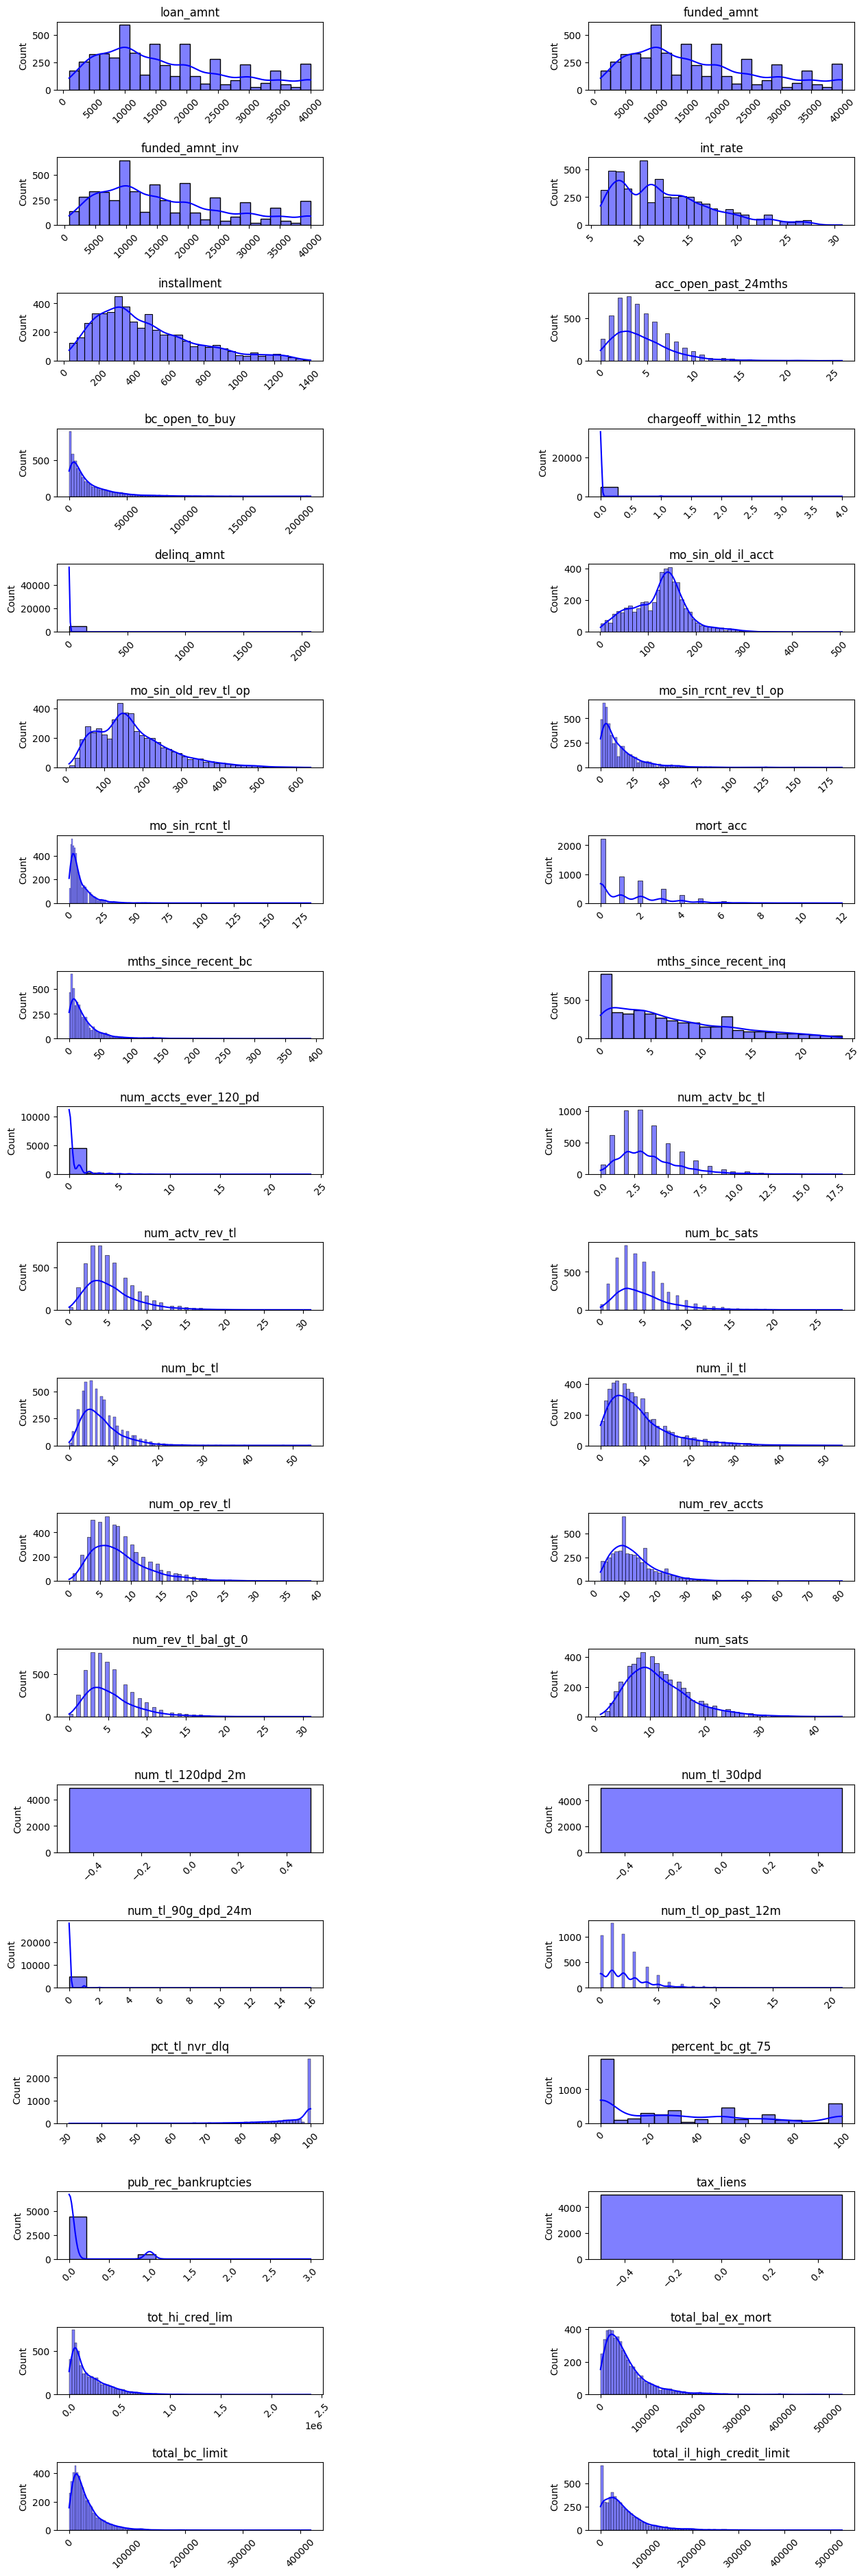

In [56]:
import math

num_columns = len(df_pd_num.columns)  # Total de columnas
rows = math.ceil(num_columns / 2)  # 2 columnas por fila

fig, axes = plt.subplots(rows, 2, figsize=(15, rows * 2.5))  # Ajuste automático
plt.subplots_adjust(wspace=1, hspace=1)
axes = axes.ravel()

for col, ax in zip(df_pd_num.columns, axes):
    sns.histplot(data=df_pd_num, x=col, kde=True, ax=ax, color="blue")
    ax.set(title=f'{col}', xlabel=None)
    ax.tick_params(axis='x', rotation=45)

plt.show()

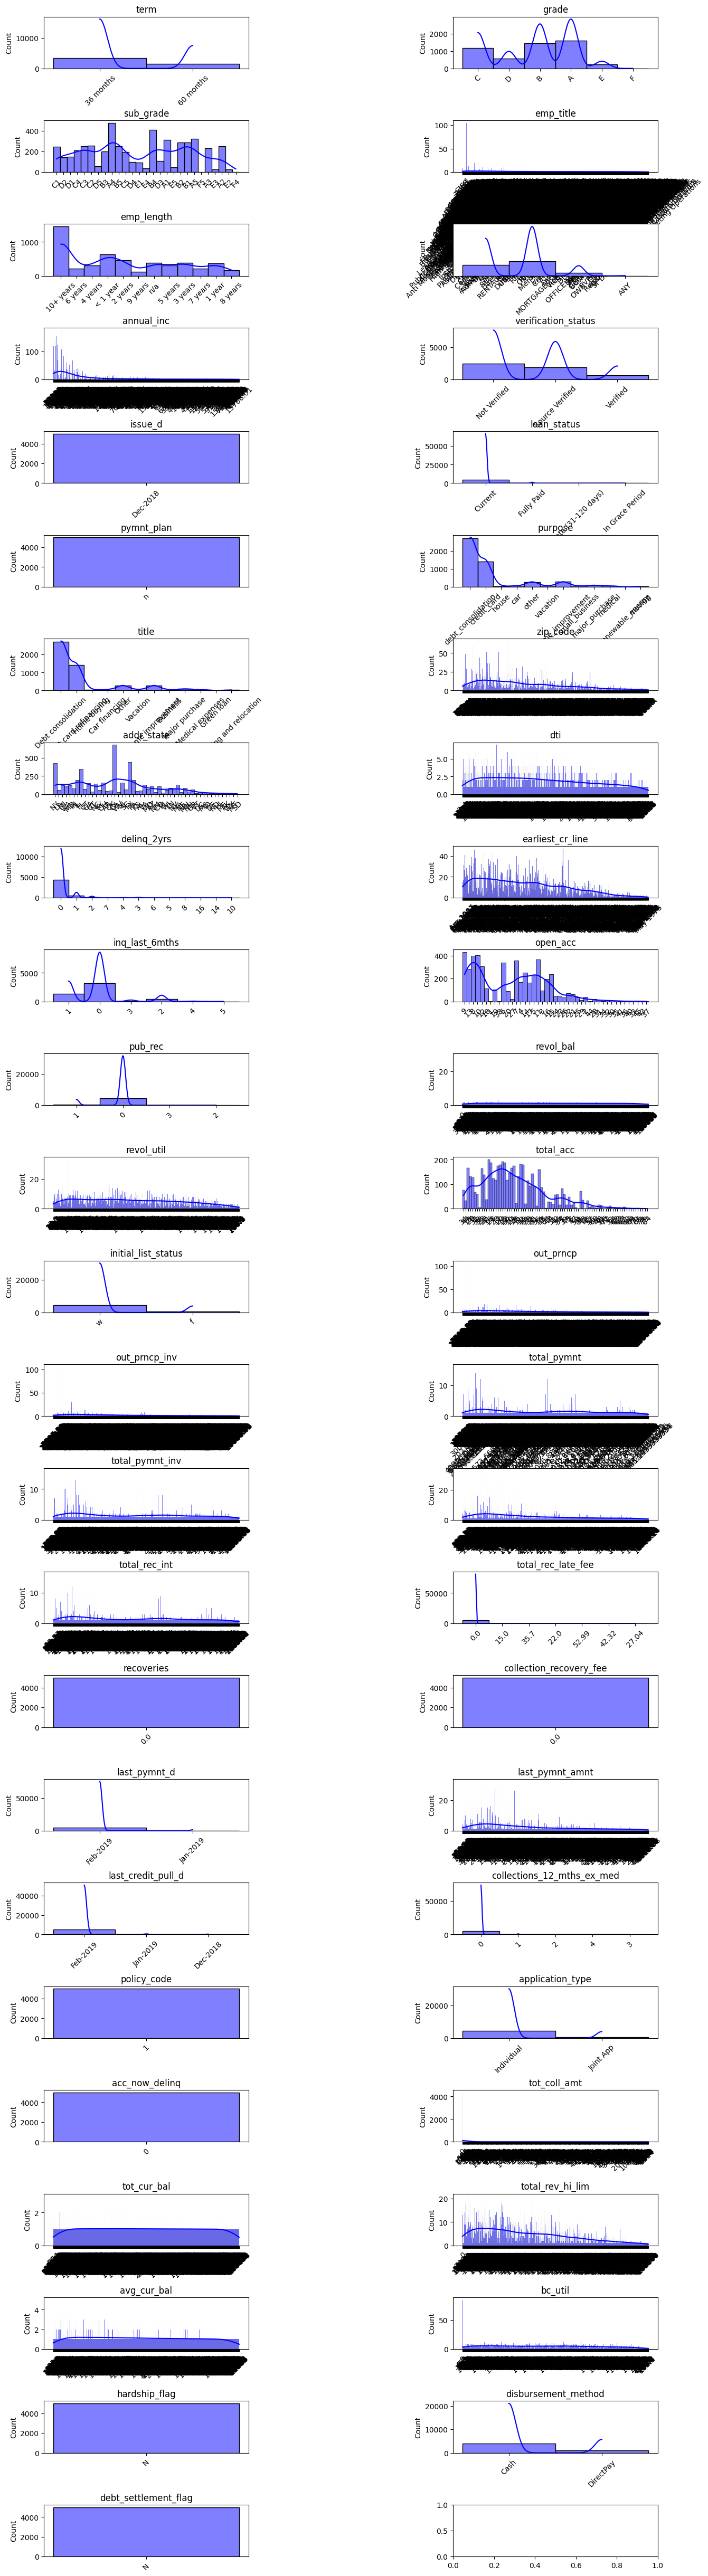

In [45]:
import math

num_columns = len(df_pd_str.columns)  # Total de columnas
rows = math.ceil(num_columns / 2)  # 2 columnas por fila

fig, axes = plt.subplots(rows, 2, figsize=(15, rows * 2.5))  # Ajuste automático
plt.subplots_adjust(wspace=1, hspace=1)
axes = axes.ravel()

for col, ax in zip(df_pd_str.columns, axes):
    sns.histplot(data=df_pd_str, x=col, kde=True, ax=ax, color="blue")
    ax.set(title=f'{col}', xlabel=None)
    ax.tick_params(axis='x', rotation=45)

plt.show()

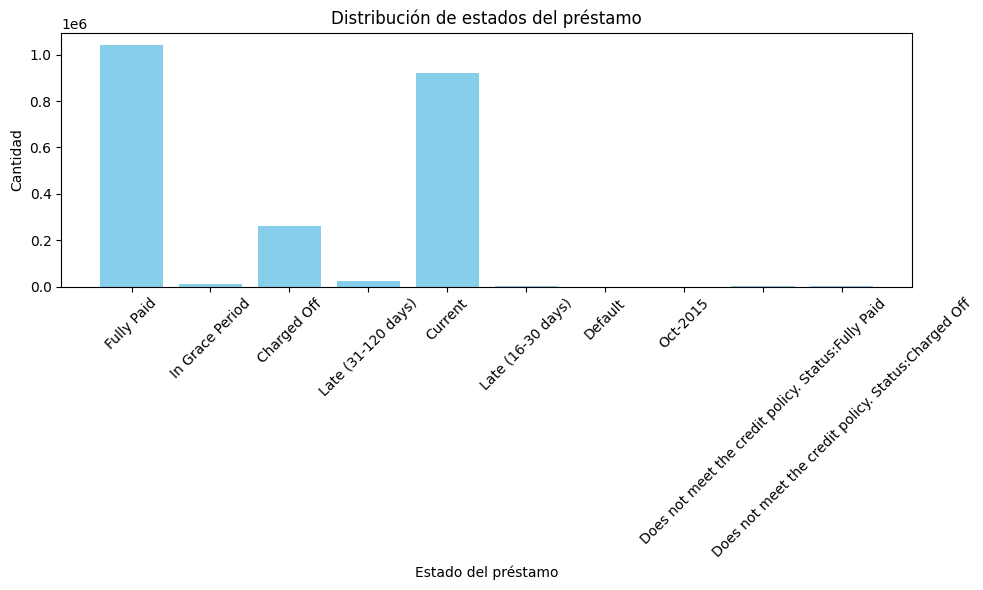

In [50]:
import matplotlib.pyplot as plt
loan_status_counts = df_clean.groupBy("loan_status").count().toPandas()
plt.figure(figsize=(10,6))
plt.bar(loan_status_counts['loan_status'], loan_status_counts['count'], color='skyblue')
plt.title('Distribución de estados del préstamo')
plt.xlabel('Estado del préstamo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


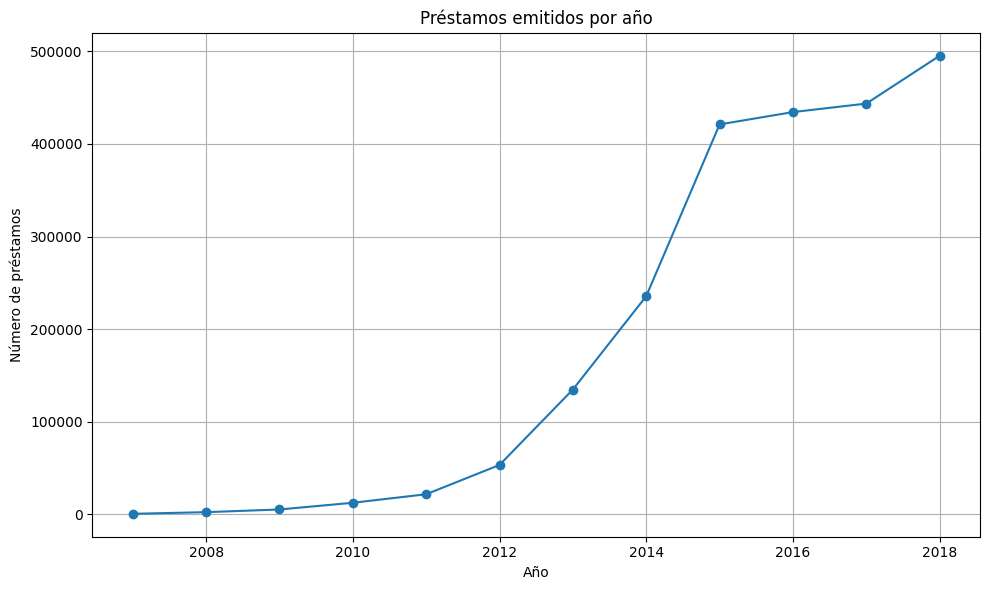

In [51]:
loans_by_year = df_clean.groupBy("issue_year").count().orderBy("issue_year").toPandas()
plt.figure(figsize=(10,6))
plt.plot(loans_by_year["issue_year"], loans_by_year["count"], marker="o")
plt.title("Préstamos emitidos por año")
plt.xlabel("Año")
plt.ylabel("Número de préstamos")
plt.grid(True)
plt.tight_layout()
plt.show()


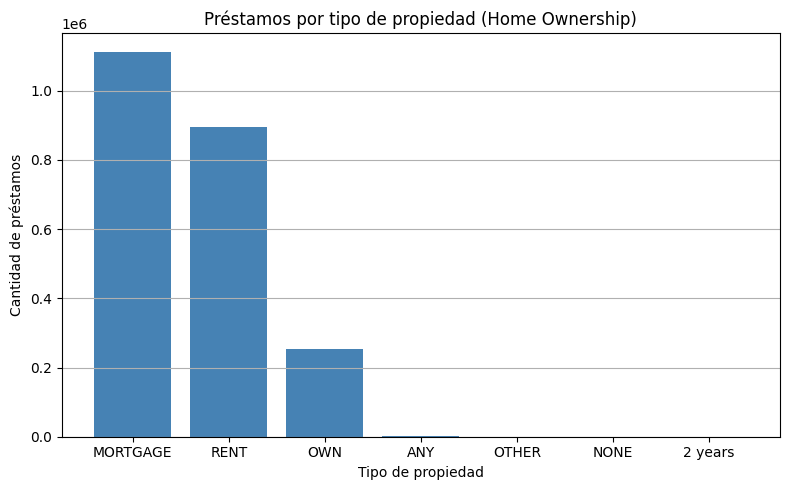

In [52]:
home_df = df_clean.groupBy("home_ownership").count().orderBy("count", ascending=False).toPandas()
plt.figure(figsize=(8,5))
plt.bar(home_df["home_ownership"], home_df["count"], color='steelblue')
plt.title("Préstamos por tipo de propiedad (Home Ownership)")
plt.xlabel("Tipo de propiedad")
plt.ylabel("Cantidad de préstamos")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

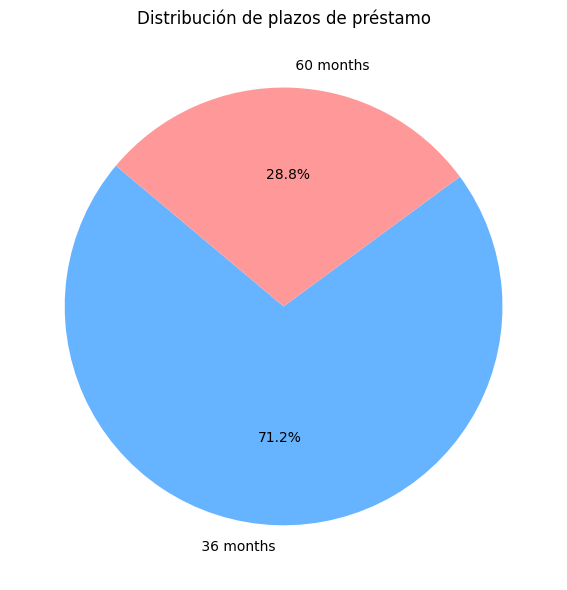

In [53]:
term_df = df_clean.groupBy("term").count().toPandas()
plt.figure(figsize=(6,6))
plt.pie(term_df["count"], labels=term_df["term"], autopct='%1.1f%%', startangle=140, colors=["#66b3ff", "#ff9999"])
plt.title("Distribución de plazos de préstamo")
plt.tight_layout()
plt.show()